# Generate final LLM DVs per tasl

Starting point:
- dataset with itemlevel values for each task for each model

Goal:
- calculate the final DVs (orient at how Frey caculated the DVs from the item values of the participants)

In [1]:
# packages and data

import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from utils import load_dataframes
from scipy.stats import pearsonr
import random
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import pingouin as pg
import seaborn as sns
import ast


# load overall df
all_data = pd.read_csv("processed_data/items_per_LLM.csv")

### AUDIT SCALE

### BARRAT SCALE
- if I understand it correctly (no docu) sum per subscale

In [2]:
BARRAT_SUB= all_data[all_data["experiment"] == "BARRAT scale"]
BARRAT_DV_DF = BARRAT_SUB.groupby(["model", "category"])["score"].sum().reset_index()
BARRAT_DV_DF = BARRAT_DV_DF.pivot(index="model", columns="category", values="score")


### CARE SCALE

### DAST SCALE

### DM SCALE

In [3]:
DM_SUB= all_data[all_data["experiment"] == "Dm scale"]
DM_DV_DF = DM_SUB.groupby(["model"])["score"].sum().reset_index() # not happy yet! (1-3 instead of 0 to 2, plus 4="not applicable" still in the data)
#DM_DV_DF

### DOSPERT SCALE
- if I understand it correctly (no docu) mean per subscale

In [4]:
DOSPERT_SUB= all_data[all_data["experiment"] == "DOSPERT scale"]
DOSPERT_DV_DF = DOSPERT_SUB.groupby(["model", "category"])["score"].mean().reset_index()
DOSPERT_DV_DF = DOSPERT_DV_DF.pivot(index="model", columns="category", values="score")


### FTND SCALE

### GABS SCALE

### PG SCALE

### PRI SCALE

### SOEP SCALE

- simply stays the same, every value in one sub category is one value

In [5]:
SOEP_SUB= all_data[all_data["experiment"] == "SOEP scale"]
SOEP_DV_DF = SOEP_SUB.pivot(index="model", columns="category", values="score")

### SSSV SCALE

In [6]:
SSSV_SUB= all_data[all_data["experiment"] == "SSSV scale"]
SSSV_DV_DF = SSSV_SUB.groupby(["model", "category"])["score"].sum().reset_index()
SSSV_DV_DF = SSSV_DV_DF.pivot(index="model", columns="category", values="score")


### BART TASK

- mean number of pumps over trials (items)

In [7]:
BART_SUB= all_data[all_data["experiment"] == "BART task"]
BART_DV_DF = BART_SUB.groupby(["model"])["score"].mean().reset_index()
#BART_DV_DF

### CCT TASK
- sum of all cards drawn (scores of all items per person summed up)

In [8]:
CCT_SUB= all_data[all_data["experiment"] == "CCT task"]
CCT_DV_DF = CCT_SUB.groupby(["model"])["score"].sum().reset_index()
#CCT_DV_DF

In [9]:
# add_new_df
DV_data = pd.merge(BART_DV_DF[["model", "score"]], 
                    CCT_DV_DF[["model", "score"]], 
                    on="model",
                    how = "outer",
                    suffixes = ["_BART", "_CCT"])


### DFD TASK

- DFD re is the proportion of risky choices out of all choices
- i.e. sum(choices)/len(choices), mean
- in human samples, the item answers would all be "0" or "1", but since we already weighed with all human answers, we already have decimal numbers between 0 and 1, indicating more fine-grained answers per item already

In [10]:
DFD_SUB= all_data[all_data["experiment"] == "DFD task"]
DFD_DV_DF = DFD_SUB.groupby(["model"])["score"].mean().reset_index()
#DFD_DV_DF

In [11]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    DFD_DV_DF[["model", "score"]].rename(columns={"score": "score_DFD"}),
    on="model",
    how="outer"
)

### DFE TASK
- same as DFD
- DFE re is the proportion of risky choices out of all choices
- i.e. sum(choices)/len(choices), mean
- in human samples, the item answers would all be "0" or "1", but since we already weighed with all human answers, we already have decimal numbers between 0 and 1, indicating more fine-grained answers per item already

In [12]:
DFE_SUB= all_data[all_data["experiment"] == "DFE task"]
DFE_DV_DF = DFE_SUB.groupby(["model"])["score"].mean().reset_index()
#DFE_DV_DF

In [13]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    DFE_DV_DF[["model", "score"]].rename(columns={"score": "score_DFE"}),
    on="model",
    how="outer"
)

### LOT TASK

- mean i.e. proportion of risky choices out of the 25 trials.

In [14]:
LOT_SUB= all_data[all_data["experiment"] == "LOT task"]
LOT_DV_DF = LOT_SUB.groupby(["model"])["score"].mean().reset_index()
#LOT_DV_DF

In [15]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    LOT_DV_DF[["model", "score"]].rename(columns={"score": "score_LOT"}),
    on="model",
    how="outer"
)

### MPL TASK
- switching point:
    - only the first of all rounds is taken into consideration
    - there it is looked at the switching point (the first decision for the riskier choice)

- I will also only consider the first round, look at the scores and round probabilities under 0.5 to 0 and from 0.5 on to 1. 
- then I will define the switching point of a model as the first 1 decision. (=DV)

In [16]:
# filter only MPL data and filter only data for the first round, (since round 2-7 are ignored for the DV)
MPL_SUB= all_data[all_data["experiment"] == "MPL task"]
MPL_SUB['item'] = MPL_SUB['item'].apply(ast.literal_eval)
MPL_SUB_ROUND_1 = MPL_SUB[MPL_SUB['item'].apply(lambda x: x[0] == 1)]


/var/folders/g6/6tx7kz_51_92m63qx0q2c2lw0000gn/T/ipykernel_21030/2303537433.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MPL_SUB['item'] = MPL_SUB['item'].apply(ast.literal_eval)


In [17]:
# define the switching point by first transforming all scores to 0 or 1 (depends on whether they are bigger than 0.5)
MPL_SUB_ROUND_1["decision"] = np.where(
    MPL_SUB_ROUND_1["score"] <= 0.5,
    0,
    1
)

#MPL_SUB_ROUND_1.tail(50)

/var/folders/g6/6tx7kz_51_92m63qx0q2c2lw0000gn/T/ipykernel_21030/1789067762.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MPL_SUB_ROUND_1["decision"] = np.where(


In [18]:
# not yet happy with, current sum up technique to simulate switching point
MPL_DV_DF = MPL_SUB_ROUND_1.groupby(["model"])["decision"].sum().reset_index()
#MPL_DV_DF

In [19]:
# add_new_df
DV_data = pd.merge(
    DV_data,
    MPL_DV_DF[["model", "decision"]].rename(columns={"decision": "score_MPL"}),
    on="model",
    how="outer"
)

## Merge all into one final DV-dataframe

## Preliminary Results

In [20]:
DV_data

,model,score_BART,score_CCT,score_DFD,score_DFE,score_LOT,score_MPL
0,Apertus-70B-Instruct-2509,37.241372,NaN,0.481030,0.404648,0.467364,4
1,Apertus-8B-Instruct-2509,36.242104,372.845962,0.478926,0.407979,0.470032,4
2,Falcon-3-10B-Instruct,35.034919,417.629864,0.460127,0.398377,0.473275,4
3,Falcon-3-1B-Instruct,37.323391,469.930092,0.491993,0.405875,0.457771,3
4,Falcon-3-7B-Instruct,32.649478,376.093692,0.456017,0.412555,0.485819,4
5,LFM2-1.2B,37.790812,454.925180,0.495304,0.427808,0.436834,4
6,LFM2-2.6B,37.830328,465.918091,0.489709,0.405567,0.433390,3
7,LFM2-8B-A1B,37.606420,468.879555,0.495102,0.401295,0.486672,4
8,Llama-3.1-70B-Instruct,31.465533,453.462592,0.459639,0.402853,0.465361,4
9,Llama-3.1-8B-Instruct,34.116821,424.047667,0.470051,0.405385,0.463547,4


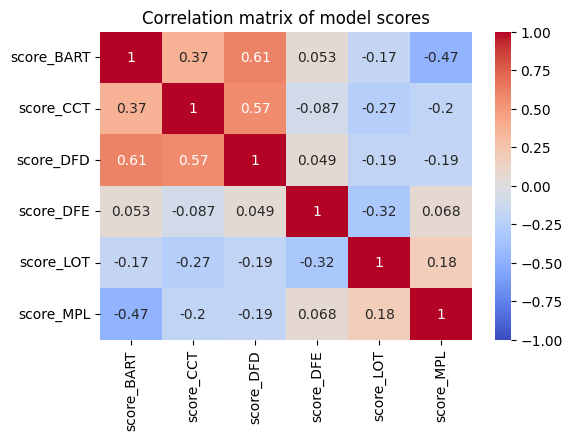

In [21]:
# Compute correlation matrix (only for numeric columns)
corr = DV_data[["score_BART", "score_CCT", "score_DFD", "score_DFE", "score_LOT", "score_MPL"]].corr()

# Display it as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation matrix of model scores")
plt.show()
